In [1]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import torchvision.models as models
import torchvision.utils as utils

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    print("No Cuda")

Running on the GPU


In [3]:
# parameters:
batch_size = 64
learning_rate = 0.001
momentum = 0.5
epoch = 10

In [4]:
def get_MNIST(transform):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Lambda(lambda x:x.repeat(3,1,1)),
         transform]
    )
    train_dataset = datasets.MNIST(root=r'D:\\InternWorkspace_wsr\\dataset',train=True,download=True,transform=transform)
    test_dataset = datasets.MNIST(root=r'D:\\InternWorkspace_wsr\\dataset',train=False,download=True,transform=transform)
    return train_dataset,test_dataset

In [5]:
def get_dataloader(train_dataset,test_dataset):
    # dataloader
    train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size = batch_size,
                                shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset,
                                batch_size = 1,
                                shuffle=True)
    return train_dataloader,test_dataloader

In [6]:
# ResNet18
resnet18 = models.resnet18()
resnet18_weights = torch.load('./weights/resnet18-f37072fd.pth')
resnet18.load_state_dict(resnet18_weights)
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# # 第一种方法：直接修改
# modify parameter:
# fc output(原)：1000 -> 10
resnet18_fc_features = resnet18.fc.in_features
resnet18.fc = torch.nn.modules.Linear(resnet18_fc_features,10)

In [8]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# 第二种方法：冻结之前层的参数，微调最后一层
for param in resnet18.parameters():
    param.requires_grad = False
# 解冻fc层
for param in resnet18.fc.parameters():
    param.requires_grad = True

In [11]:
# preprcossed:
resnet18_trans = models.ResNet18_Weights.DEFAULT.transforms()
train_dataset,test_dataset = get_MNIST(resnet18_trans)
train_dataloader,test_dataloader = get_dataloader(train_dataset,test_dataset)

In [16]:
# Finetune ResNet18
# train:
def finetune(model,train_dataloader,model_path):
    model.train()
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

    loss_lists = []
    for e in tqdm(range(epoch)):
        train_loss = 0
        total = 0
        correct = 0
        for _ ,data in enumerate(train_dataloader):
            optimizer.zero_grad()
            inputs,targets = data
            # to GPU
            inputs,targets = inputs.to(device),targets.to(device)
            # train
            outputs = model(inputs)
            loss = criterion(outputs,targets)
            # loss
            loss.backward()
            optimizer.step()
            
            # compute:
            train_loss += loss.item()
            _,predicted = torch.max(outputs.data,dim=1)
            total+=inputs.shape[0]
            correct+=(targets==predicted).sum().item()
            
            
        # save loss:
        loss_lists.append(loss.cpu().detach().numpy())
        acc = correct/total*100
        print("epoch {}: loss {} acc {}".format(e,loss,acc))
    
    # save model
    torch.save(model,model_path)
    print("Save Model in {} Successfully!".format(model_path))

    # show loss curve:
    fig = plt.figure()
    plt.plot(np.arange(0,len(loss_lists),1),loss_lists)
    plt.title("Loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.show()
    plt.close(fig)

 10%|█         | 1/10 [00:54<08:09, 54.39s/it]

epoch 0: loss 0.10894062370061874 acc 92.09333333333333


 20%|██        | 2/10 [01:48<07:13, 54.20s/it]

epoch 1: loss 0.11812518537044525 acc 94.46833333333333


 30%|███       | 3/10 [02:42<06:19, 54.20s/it]

epoch 2: loss 0.0577479749917984 acc 95.07


 40%|████      | 4/10 [03:36<05:24, 54.16s/it]

epoch 3: loss 0.24260973930358887 acc 95.48166666666667


 50%|█████     | 5/10 [04:30<04:30, 54.12s/it]

epoch 4: loss 0.1329803466796875 acc 95.72833333333334


 60%|██████    | 6/10 [05:25<03:36, 54.18s/it]

epoch 5: loss 0.0757531225681305 acc 95.85833333333333


 70%|███████   | 7/10 [06:21<02:44, 54.89s/it]

epoch 6: loss 0.19859112799167633 acc 96.015


 80%|████████  | 8/10 [07:17<01:50, 55.29s/it]

epoch 7: loss 0.37091270089149475 acc 96.12166666666667


 90%|█████████ | 9/10 [08:14<00:55, 55.66s/it]

epoch 8: loss 0.189121276140213 acc 96.19666666666666


100%|██████████| 10/10 [09:10<00:00, 55.07s/it]

epoch 9: loss 0.15413087606430054 acc 96.315
Save Model in ./weights/checkpoints/Resnet18_ft.pth Successfully!


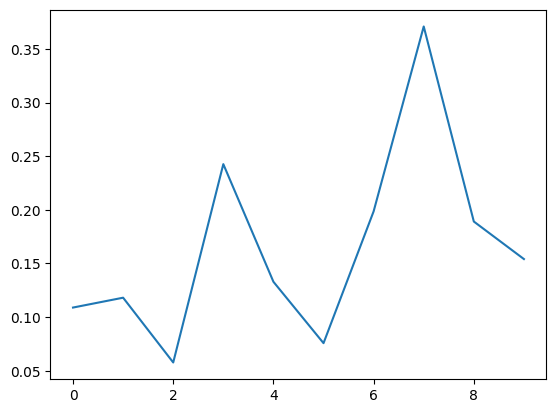

In [17]:
model_path = './weights/checkpoints/Resnet18_ft.pth'
finetune(resnet18,train_dataloader,model_path)

In [18]:
def predict(model):
    model = model.to(device)
    # predict:
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in tqdm(test_dataloader):
            inputs,targets = data
            
            inputs,targets = inputs.to(device),targets.to(device)
            outputs = model(inputs)
            
            _,predicted = torch.max(outputs.data,dim=1)
            total += inputs.shape[0]
            correct+=(targets==predicted).sum().item()
            
    acc = correct/total*100
    print("Acc in test dataset: {}%".format(acc))

In [20]:
model_ft = torch.load(model_path)
predict(model_ft)

  0%|          | 0/10000 [00:00<?, ?it/s]d:\InternWorkspace_wsr\torchenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 10000/10000 [00:21<00:00, 455.06it/s]

Acc in test dataset: 96.11
